**This notebook analyses possible correlations between hateful speech on 4chan and socioeconomic factors in the USA**

In [58]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import datetime as dt
import matplotlib.pylab as plt

import all counts into one dataframe

In [59]:
pol_counts = ["./Counts/pol_counts_part0.csv","./Counts/pol_counts_part1.csv"]
news_counts = "./Counts/news_counts.csv"
sci_counts = "./Counts/sci_counts.csv"
adv_counts = "./Counts/adv_counts.csv"

In [60]:
pol_counts = pd.read_csv(pol_counts[0],index_col=0).append(pd.read_csv(pol_counts[1], index_col=0))
sci_counts = pd.read_csv(sci_counts, index_col=0)
news_counts = pd.read_csv(news_counts, index_col=0)
adv_counts = pd.read_csv(adv_counts, index_col=0)

define hate_count column as number of hateful words

In [61]:
def countWords(text):
    try:
        return min(1,len(text.split(" ")))
    except Exception:
        return 0

In [62]:
pol_counts.loc[:,"board"] = "pol"
sci_counts.loc[:,"board"] = "sci"
adv_counts.loc[:,"board"] = "adv"
news_counts.loc[:,"board"] = "news"

In [63]:
for df in [pol_counts,sci_counts,adv_counts,news_counts]:
    df.loc[:,"hate_count"] = df.loc[:,"matched_vocab"].map(countWords)
    df.loc[:,'date'] = pd.to_datetime(df.loc[:,"timestamp"], unit='s')
    df.loc[:,'month'] = pd.to_datetime(df.loc[:,"date"]).dt.to_period('M')

convert timestamp to date and month

group by month and calculate sum of hate_count

In [64]:
pol_hate_share_monthly = pol_counts.groupby("month").sum()["hate_count"] / pol_counts.groupby("month")["content"].count()
sci_hate_share_monthly = sci_counts.groupby("month").sum()["hate_count"] / sci_counts.groupby("month")["content"].count()
adv_hate_share_monthly = adv_counts.groupby("month").sum()["hate_count"] / adv_counts.groupby("month")["content"].count()
news_hate_share_monthly = news_counts.groupby("month").sum()["hate_count"] / news_counts.groupby("month")["content"].count()

In [65]:
sci_hate_share_monthly.head()

month
2010-05    0.059417
2010-06    0.058848
2010-07    0.072431
2010-08    0.065405
2010-09    0.071923
Freq: M, dtype: float64

In [66]:
hate_share_monthly = pd.DataFrame(index=sci_hate_share_monthly.index, columns=["sci","news","adv","pol"])
hate_share_monthly.loc[sci_hate_share_monthly.index, "sci"] = sci_hate_share_monthly
hate_share_monthly.loc[:,'news'] = news_hate_share_monthly
hate_share_monthly.loc[:, "adv"] = adv_hate_share_monthly
hate_share_monthly.loc[:, "pol"] = pol_hate_share_monthly
hate_share_monthly.tail()

,sci,news,adv,pol
month,,,,
2021-08,0.106599,0.122677,0.181448,0.187663
2021-09,0.093541,0.120763,0.188089,0.192037
2021-10,0.103524,0.131843,0.175117,0.204550
2021-11,0.109521,0.116179,0.165316,0.195880
2021-12,0.099878,0.144330,0.151316,0.174427


***standardize all columns***

In [67]:
def standardize(data: pd.Series) -> pd.Series:
    return (data - data.median()) / data.std()

In [68]:
hate_share_monthly = hate_share_monthly.apply(standardize,axis=0)

In [69]:
hate_share_monthly.head()

,sci,news,adv,pol
month,,,,
2010-05,-0.972368,NaN,NaN,NaN
2010-06,-1.008734,NaN,NaN,NaN
2010-07,-0.140081,NaN,NaN,NaN
2010-08,-0.589395,NaN,NaN,NaN
2010-09,-0.172575,NaN,NaN,NaN


<AxesSubplot:xlabel='month'>

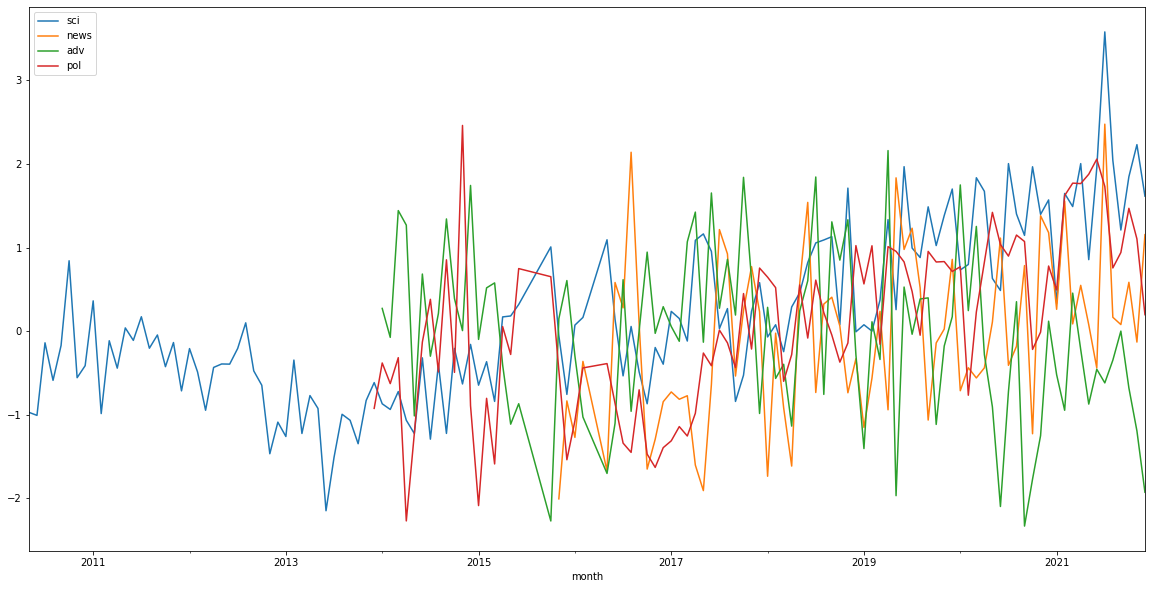

In [70]:
hate_share_monthly.plot.line(figsize=(20,10))

***Import and prepare series on monthly change in hourly wages***

In [71]:
us_hourly_wages = pd.read_csv("./usa_indicators/us_real_hourly_earnings_monthly.csv", index_col=3)
us_hourly_wages = us_hourly_wages.drop(["Series ID","Year","Period"], axis=1)
us_hourly_wages.head()

,Value
Label,
2010 Jan,10.30
2010 Feb,10.33
2010 Mar,10.33
2010 Apr,10.34
2010 May,10.37


In [72]:
new_index = pd.Series(us_hourly_wages.index)
new_index = pd.to_datetime(new_index).dt.to_period("M")
new_index.head()

0    2010-01
1    2010-02
2    2010-03
3    2010-04
4    2010-05
Name: Label, dtype: period[M]

In [73]:
us_hourly_wages.index = pd.Index(new_index, name="Month")
us_hourly_wages = us_hourly_wages.loc[:,"Value"]
us_hourly_wages = us_hourly_wages.map(np.float64)
us_hourly_wages.head()

Month
2010-01    10.30
2010-02    10.33
2010-03    10.33
2010-04    10.34
2010-05    10.37
Freq: M, Name: Value, dtype: float64

In [74]:
def unemploymentData(path) -> pd.Series:
    df = pd.read_csv(path, index_col=3).drop(["Series ID","Year","Period"], axis=1)
    new_index = pd.Series(df.index)
    new_index = pd.to_datetime(new_index).dt.to_period("M")
    df.index = pd.Index(new_index, name="Month")
    df = df.loc[:,"Value"]
    df = df.map(np.float64)
    return df

***Import and prepare monthly unemployment***

In [75]:
us_unemployment_monthly = unemploymentData("./usa_indicators/us_unemployment_monthly.csv")
us_unemployment_monthly.head()

Month
2010-01    9.8
2010-02    9.8
2010-03    9.9
2010-04    9.9
2010-05    9.6
Freq: M, Name: Value, dtype: float64

In [76]:
us_unemployment_monthly_youth = unemploymentData("./usa_indicators/us_unemployment_monthly_16to19_yrs.csv")
us_unemployment_monthly_youth.head()

Month
2010-01    26.1
2010-02    25.6
2010-03    26.2
2010-04    25.4
2010-05    26.5
Freq: M, Name: Value, dtype: float64

In [77]:
us_unemployment_monthly_mid = unemploymentData("./usa_indicators/us_unemployment_monthly_25to54_yrs.csv")
us_unemployment_monthly_mid.head()

Month
2010-01    8.8
2010-02    8.8
2010-03    8.9
2010-04    8.8
2010-05    8.7
Freq: M, Name: Value, dtype: float64

***Extract monthly changes***

In [78]:
us_unemployment_monthly_youth_change = us_unemployment_monthly_youth.pct_change().dropna() * 100
us_unemployment_monthly_mid_change = us_unemployment_monthly_mid.pct_change().dropna() * 100
us_hourly_wages_change = us_hourly_wages.pct_change().dropna() * 100

***Build combined dataset of all factors***

In [79]:
us_indicators = pd.DataFrame(index=us_unemployment_monthly.index)
us_indicators.loc[:,"unemployment youth"] = us_unemployment_monthly_youth
us_indicators.loc[:,"unemployment mid aged"] = us_unemployment_monthly_mid
us_indicators.loc[:,"hourly wages"] = us_hourly_wages
us_indicators.loc[:,"unemployment youth change"] = us_unemployment_monthly_youth_change
us_indicators.loc[:,"unemployment mid aged change"] = us_unemployment_monthly_mid_change
us_indicators.loc[:,"hourly wages change"] = us_hourly_wages_change
us_indicators.index = pd.Index(us_indicators.index, name="Month")
us_indicators = us_indicators.apply(standardize, axis=0)
us_indicators.head()

,unemployment youth,unemployment mid aged,hourly wages,unemployment youth change,unemployment mid aged change,hourly wages change
Month,,,,,,
2010-01,1.811110,1.930303,-0.912584,NaN,NaN,NaN
2010-02,1.716781,1.930303,-0.834362,-0.088891,0.056370,0.562173
2010-03,1.829975,1.979798,-0.834362,0.244861,0.108255,0.000000
2010-04,1.679050,1.930303,-0.808289,-0.178038,0.005067,0.186847
2010-05,1.886573,1.880808,-0.730067,0.400551,0.004484,0.559998


***Plot lines***

<AxesSubplot:xlabel='Month', ylabel='Normalized'>

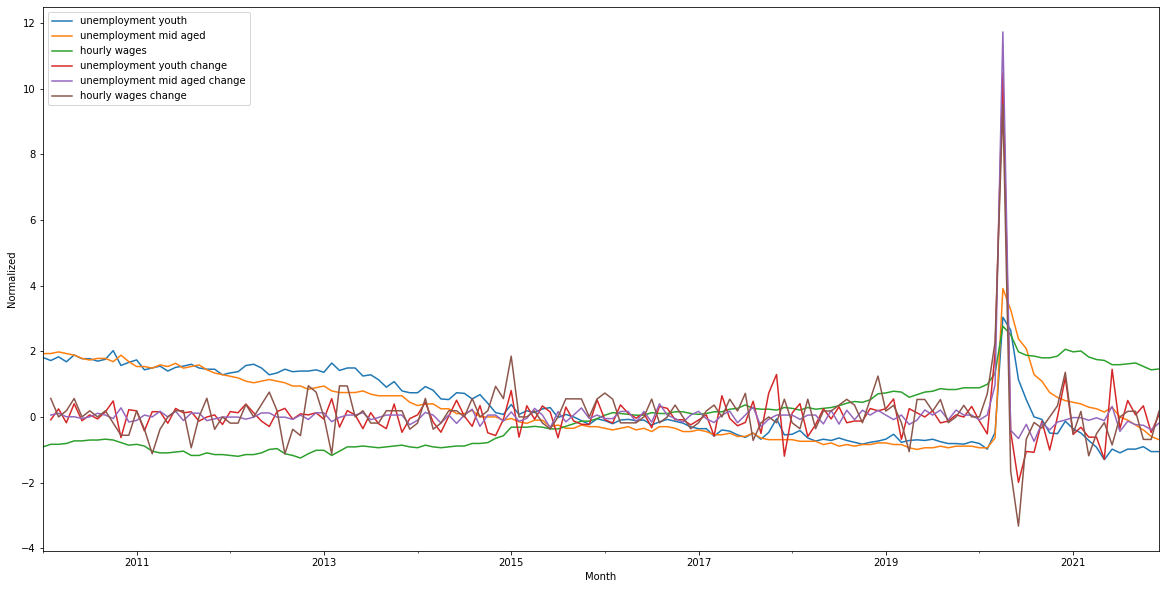

In [80]:
us_indicators.plot.line(figsize=(20,10), ylabel="Normalized")

***Shift indicators one period to the left***

In [81]:
us_indicators_shifted = us_indicators.copy()

In [82]:
for indicator in us_indicators.columns:
    us_indicators_shifted.loc[:,f"{indicator} shift -1"] = np.repeat(np.NaN, len(us_indicators_shifted.index))
    us_indicators_shifted.loc[:,f"{indicator} shift -1"].iloc[1:] = us_indicators_shifted.loc[:,indicator].iloc[:-1]
    us_indicators_shifted = us_indicators_shifted.drop(indicator, axis=1)

***Inspect covariances***

In [95]:
hourly_wages_cov = hate_share_monthly.join(us_indicators.loc[:,"hourly wages"]).cov()
unemployment_youth_cov = hate_share_monthly.join(us_indicators.loc[:,"unemployment youth"]).cov()
unemployment_mid_cov = hate_share_monthly.join(us_indicators.loc[:,"unemployment mid aged"]).cov()
hourly_wages_change_cov = hate_share_monthly.join(us_indicators.loc[:,"hourly wages change"]).cov()
unemployment_youth_change_cov = hate_share_monthly.join(us_indicators.loc[:,"unemployment youth change"]).cov()
unemployment_mid_change_cov = hate_share_monthly.join(us_indicators.loc[:,"unemployment mid aged change"]).cov()
hourly_wages_shifted_cov = hate_share_monthly.join(us_indicators_shifted.loc[:,"hourly wages shift -1"]).cov()
unemployment_youth_shifted_cov = hate_share_monthly.join(us_indicators_shifted.loc[:,"unemployment youth shift -1"]).cov()
unemployment_mid_shifted_cov = hate_share_monthly.join(us_indicators_shifted.loc[:,"unemployment mid aged shift -1"]).cov()
hourly_wages_change_shifted_cov = hate_share_monthly.join(us_indicators_shifted.loc[:,"hourly wages change shift -1"]).cov()
unemployment_youth_change_shifted_cov = hate_share_monthly.join(us_indicators_shifted.loc[:,"unemployment youth change shift -1"]).cov()
unemployment_mid_change_shifted_cov = hate_share_monthly.join(us_indicators_shifted.loc[:,"unemployment mid aged change shift -1"]).cov()

***Generate heat map***

In [84]:
import seaborn as sb

In [85]:
def heatmap(data):
    mask = np.zeros_like(data.to_numpy())
    mask[np.triu_indices_from(mask)] = True
    with sb.axes_style("white"):
        ax = sb.heatmap(data.to_numpy(), mask=mask, vmax=1.0, vmin=-1, center=0, square=True, xticklabels=data.index, yticklabels=data.index)
        plt.show()

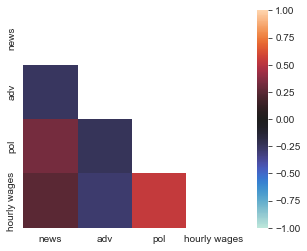

In [86]:
heatmap(hourly_wages_cov)

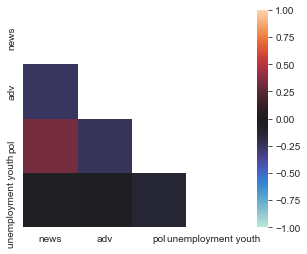

In [87]:
heatmap(unemployment_youth_cov)

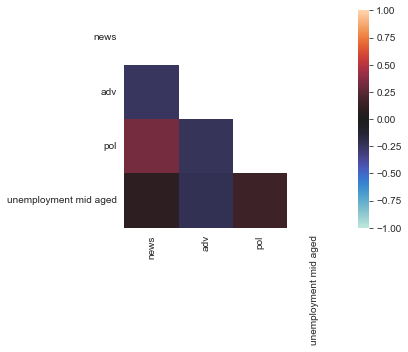

In [88]:
heatmap(unemployment_mid_cov)

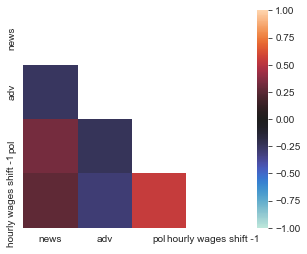

In [89]:
heatmap(hourly_wages_shifted_cov)

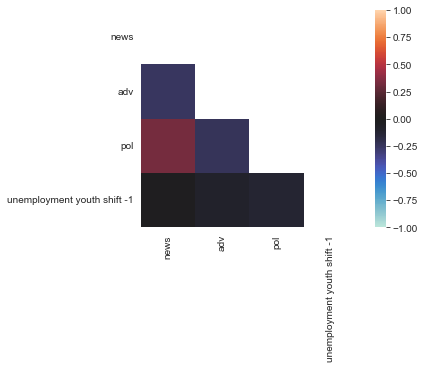

In [90]:
heatmap(unemployment_youth_shifted_cov)

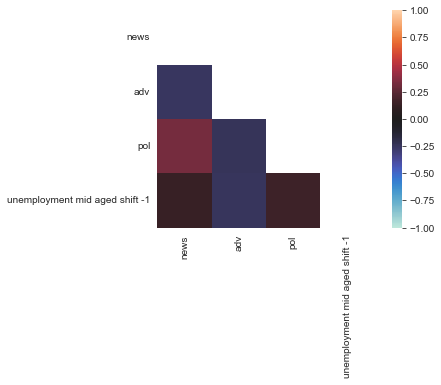

In [91]:
heatmap(unemployment_mid_shifted_cov)

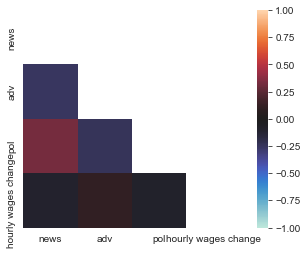

In [92]:
heatmap(hourly_wages_change_cov)

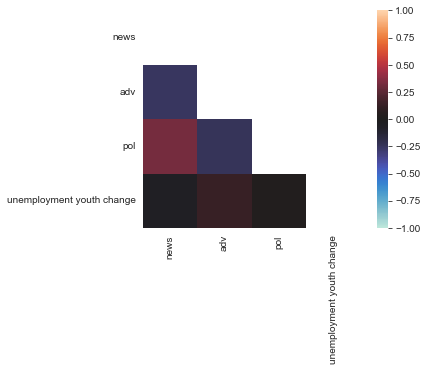

In [93]:
heatmap(unemployment_youth_change_cov)

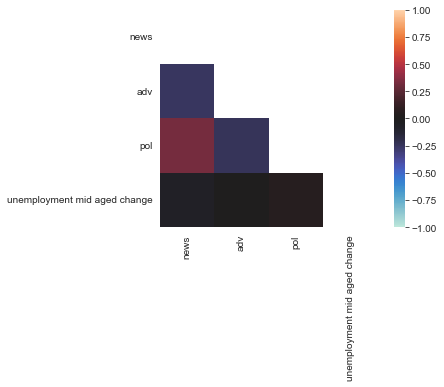

In [94]:
heatmap(unemployment_mid_change_cov)

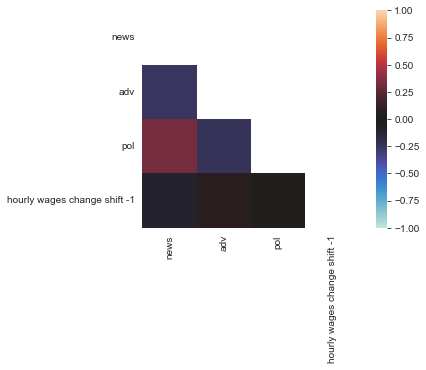

In [96]:
heatmap(hourly_wages_change_shifted_cov)

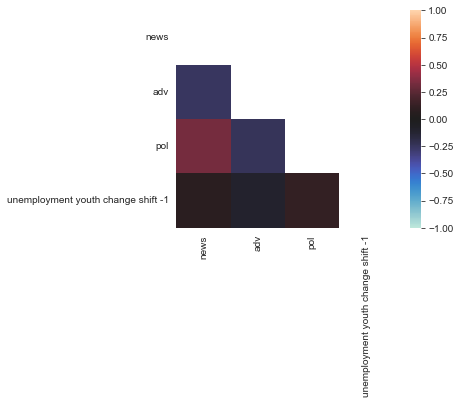

In [97]:
heatmap(unemployment_youth_change_shifted_cov)

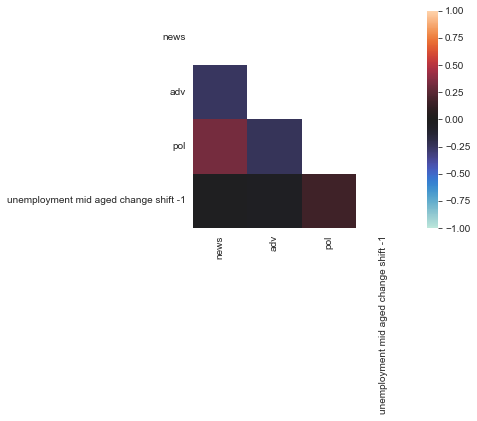

In [98]:
heatmap(unemployment_mid_change_shifted_cov)